In [1]:
from pytides.tide import Tide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import xarray as xr

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')


src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from log_progress import log_progress

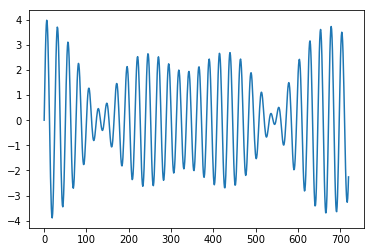

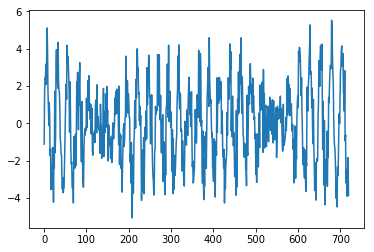

In [23]:
periods = [23.93, 25.82, 24.07, 26.87]
t = np.arange(0,30*24)
signal = np.zeros_like(t)
for p in periods:
    signal = signal + np.sin(2*np.pi/p*t)
plt.plot(t,signal)
plt.show()
tsPure = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))

noise = np.random.normal(0,1,np.size(t))
signal = signal + noise
plt.plot(t,signal)
plt.show()

ts = pd.Series(signal, index=pd.date_range("2007",freq='H',periods=np.size(signal)))

In [3]:
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path)

grid_path = os.path.join(raw_dir,'waom_frc','waom4_grd.nc')
grd = xr.open_dataset(grid_path)



In [44]:
from rotate_vector_roms import rotate_vector_roms
def get_tide(ts):
    ts = pd.Series(ts.values, index=pd.date_range("2007",freq='H',periods=np.size(ts)))
    demeaned = ts.values - ts.values.mean()
    tide = Tide.decompose(demeaned, ts.index.to_datetime())
    demeaned = Series(demeaned, index=times)
    prediction = Series(tide.at(ts.index), index=times)
    return demeaned,prediction

def calc_abs(u,v):
    return np.sqrt(np.mean(u**2+v**2))

def calc_uv_tide(u_rho,v_rho):
    
    u_dm, u_tide = get_tide(u_rho)
    v_dm, v_tide = get_tide(v_rho)
    
    uv_dm = calc_abs(u_dm,v_dm)
    uv_tide = calc_abs(u_tide,v_tide)
    
    return uv_dm, uv_tide  

def get_uv_map(u,v,mask):
    
    u_rho = np.zeros_like(mask)
    v_rho = np.zeros_like(mask)
    for i in log_progress(np.arange(u[:,0,0].size),name='time'):        
        u_rho[i],v_rho[i] = rotate_vector_roms(u[i,:],v[i,:],np.zeros_like(mask)) 
    
    demean =  np.zeros_like(mask.values)
    tide = np.zeros_like(mask.values)
    total = np.zeros_like(mask.values)
    
    for j in log_progress(mask.eta_rho.values,name='eta'):
        if mask[j,:].any()==True:        
            for i in mask.xi_rho.values:           
                if (mask[j,i]==True):
                    total[:,j,i] = calc_abs(u_rho[:,j,i],v_rho[:,j,i])
                    demean[:,j,i], tide[:,j,i] = calc_uv_tide(u_rho[:,j,i],v_rho[:,j,i])
                
    THA = xr.Dataset({'total':(['eta_rho','xi_rho'],total),
                      'demean':(['eta_rho','xi_rho'],demean),
                      'tide':(['eta_rho','xi_rho'],tide)}).where(mask)
    
    return THA

In [41]:
FRIS_t.ubar.values[0,:]

array([[-0.05370489, -0.06487387, -0.07283076, ..., -0.00217381,
         0.00354014,  0.0065664 ],
       [-0.0425359 , -0.0648786 , -0.07283461, ..., -0.00217393,
         0.00353956,  0.00959265],
       [-0.03966045, -0.03796634, -0.02974904, ..., -0.00120085,
         0.00449908,  0.00973081],
       ..., 
       [ 0.03449668,  0.0388342 ,  0.04209988, ...,  0.0211769 ,
         0.02193415,  0.02234708],
       [ 0.03959938,  0.04541291,  0.04892697, ...,  0.02308084,
         0.02313986,  0.02339146],
       [ 0.04251084,  0.0454223 ,  0.04893794, ...,  0.02309439,
         0.02315114,  0.0232713 ]], dtype=float32)

In [46]:
#subset region for testing purposes
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1000)}
#rho_sel = {'eta_rho' : slice(606,1000)}
#FRIS_nt = no_tides.isel(rho_sel)
FRIS_t = tides.sel(rho_sel)
FRIS_mask = (grd.mask_rho == 1 & (grd.zice<0)).sel(rho_sel)

In [ ]:
THA_FRIS = get_uv_map(FRIS_t.ubar.values,FRIS_t.vbar.values,FRIS_mask)

In [19]:
uv_dm,uv_tide = calc_uv_tide(800,500)

In [22]:
uv_tide

0.10468572496566884

In [10]:
ts = tides.ubar[:,800,500]
ts = pd.Series(ts.values, index=pd.date_range("2007",freq='H',periods=np.size(ts)))

In [11]:
demeaned = ts.values - ts.values.mean()
tide = Tide.decompose(demeaned, ts.index.to_datetime())

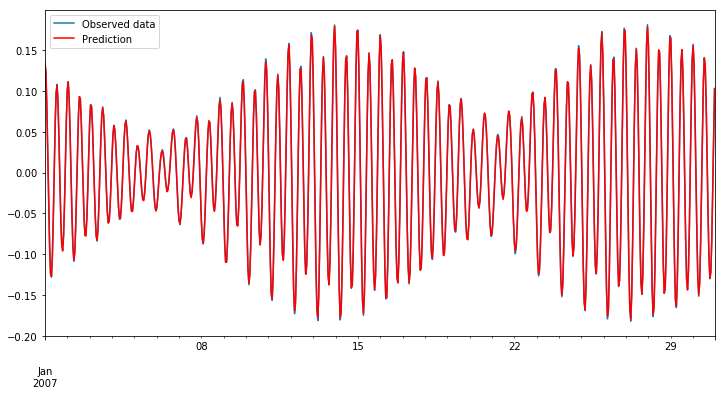

In [17]:
from pandas import Series, read_csv, date_range

times = ts.index

obs = Series(demeaned, index=times)
prediction = Series(tide.at(ts.index), index=times)

fi,ax = plt.subplots(figsize=(12,6))
ax = obs.plot(ax=ax, label='Observed data')
ax = prediction.plot(ax=ax, color='red', label='Prediction')
leg = ax.legend(loc='best')
plt.show()